In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
train_path = "../input/corn-disease/train"

In [3]:
test_path = "../input/corn-disease/test"

In [4]:
val_path = "../input/corn-disease/val"

In [5]:
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

X_train = []
Y_train = []

for target in os.listdir(train_path):
    target_path = os.path.join(train_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_train.append(file_path)
        Y_train.append(target)

100%|██████████| 954/954 [00:00<00:00, 302103.89it/s]


In [6]:
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

X_val = []
Y_val = []

for target in os.listdir(val_path):
    target_path = os.path.join(val_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_val.append(file_path)
        Y_val.append(target)

100%|██████████| 119/119 [00:00<00:00, 206419.43it/s]


In [7]:
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

X_test = []
Y_test = []

for target in os.listdir(test_path):
    target_path = os.path.join(test_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_test.append(file_path)
        Y_test.append(target)

100%|██████████| 119/119 [00:00<00:00, 267339.14it/s]


<AxesSubplot:ylabel='count'>

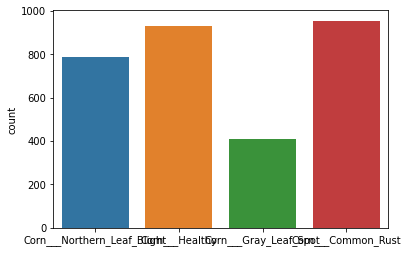

In [8]:
sns.countplot(x = Y_train)

<AxesSubplot:ylabel='count'>

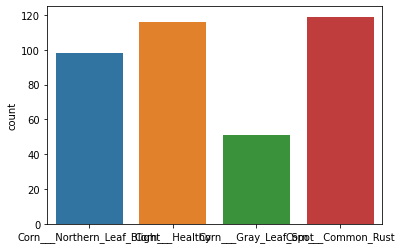

In [9]:
sns.countplot(x = Y_val)

<AxesSubplot:ylabel='count'>

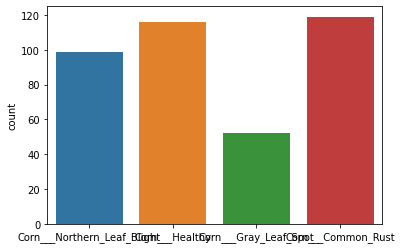

In [10]:
sns.countplot(x = Y_test)

In [11]:
df_train = pd.DataFrame(list(zip(X_train, Y_train)), columns =['image_path', 'label'])
df_val = pd.DataFrame(list(zip(X_val, Y_val)), columns =['image_path', 'label'])
df_test = pd.DataFrame(list(zip(X_test, Y_test)), columns =['image_path', 'label'])

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_aug = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator= train_aug.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

val_generator= test_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    color_mode="rgb",
    batch_size=16,
    shuffle = False, 
    target_size = (224, 224),
    class_mode="categorical")

Found 3082 validated image filenames belonging to 4 classes.
Found 384 validated image filenames belonging to 4 classes.
Found 386 validated image filenames belonging to 4 classes.


In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50, InceptionResNetV2

def generate_model(pretrained_model = 'vgg16', num_classes=3):
    if pretrained_model == 'inceptionv3':
        base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    elif pretrained_model == 'inceptionresnet':
        base_model = InceptionResNetV2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3)) # Topless
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    #Freezing Convolutional Base
    for layer in base_model.layers[:-3]:
        layer.trainable = False  
    return model

In [14]:
def train_model(model, train_generator, test_generator, num_epochs, optimizer, metrics):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=15, verbose=1)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    print(model.summary())
    
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=test_generator, verbose=1,
                        callbacks = [early_stop, rlr])
    
    return model, history

In [15]:
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

In [16]:
def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROC AUC score:", plot_roc_curves(y_true, y_pred, 4, class_labels))

In [17]:
vgg_model = generate_model('vgg16', 4)

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
vgg_model, vgg_history = train_model(vgg_model, train_generator, val_generator, 50, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


Test set accuracy: 0.9715026021003723 

25/25 [==============================] - 2s 54ms/step

                             precision    recall  f1-score   support

         Corn___Common_Rust       0.99      1.00      1.00       119
      Corn___Gray_Leaf_Spot       0.88      0.94      0.91        52
             Corn___Healthy       1.00      0.99      1.00       116
Corn___Northern_Leaf_Blight       0.97      0.93      0.95        99

                   accuracy                           0.97       386
                  macro avg       0.96      0.97      0.96       386
               weighted avg       0.97      0.97      0.97       386



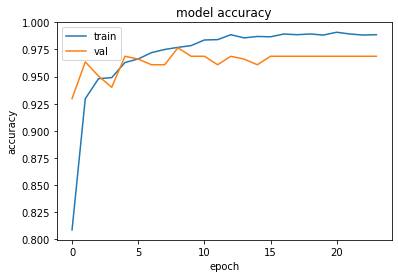

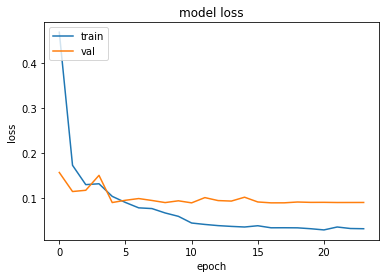

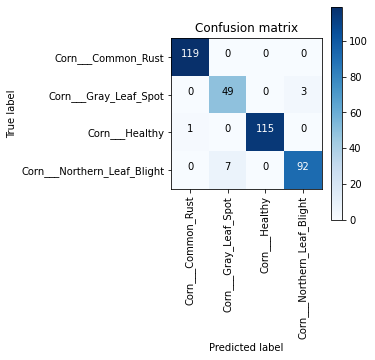

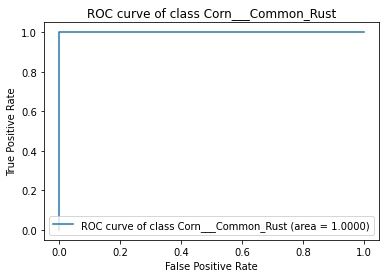

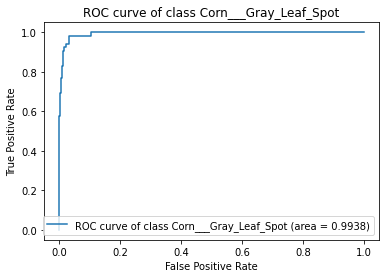

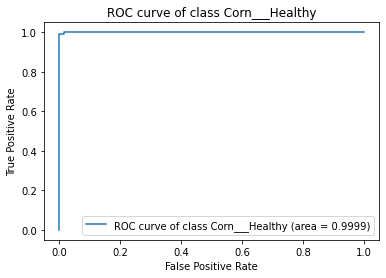

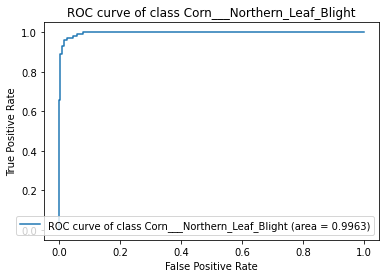

ROC AUC score: 0.9974808167140072


In [19]:
evaluate_model(vgg_model, vgg_history, test_generator)

In [20]:
vgg_model.save("/kaggle/working/vgg_model_weights.h5")

In [21]:
import pandas as pd

In [22]:
from keras.preprocessing.image import load_img,img_to_array
image_path= df_test['image_path'][101]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


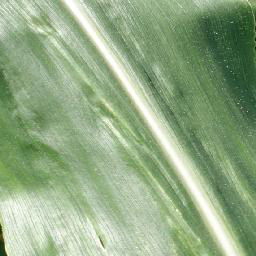

In [23]:
from PIL import Image
display(Image.open(image_path))

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.layers[-2].output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

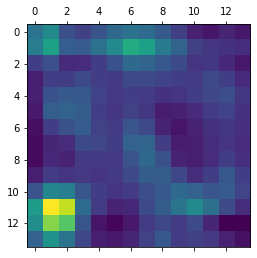

In [25]:
# Make model
model = vgg_model
last_conv_layer_name ="block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [26]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))

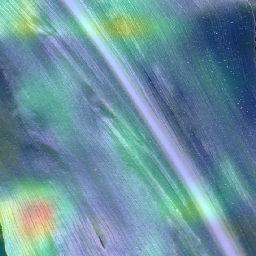

In [27]:
save_and_display_gradcam(image_path, heatmap,cam_path="/kaggle/working/GradCamTest.jpg")

In [28]:
incres_model = generate_model('inceptionresnet', 4)


219062272/219055592 [==============================] - 1s 0us/step


In [29]:
incres_model, incres_history = train_model(incres_model, train_generator, val_generator, 50, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________


Test set accuracy: 0.9715026021003723 

25/25 [==============================] - 5s 71ms/step

                             precision    recall  f1-score   support

         Corn___Common_Rust       1.00      1.00      1.00       119
      Corn___Gray_Leaf_Spot       0.89      0.90      0.90        52
             Corn___Healthy       1.00      1.00      1.00       116
Corn___Northern_Leaf_Blight       0.95      0.94      0.94        99

                   accuracy                           0.97       386
                  macro avg       0.96      0.96      0.96       386
               weighted avg       0.97      0.97      0.97       386



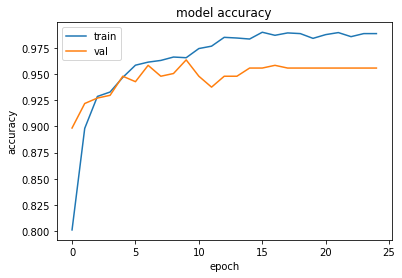

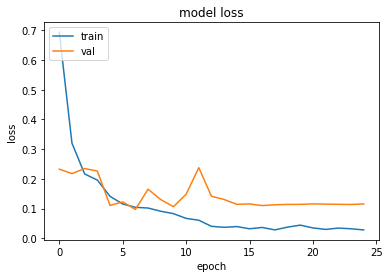

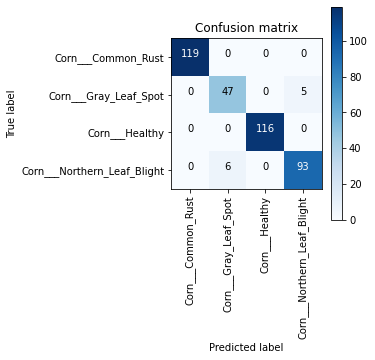

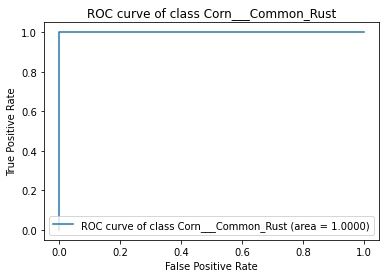

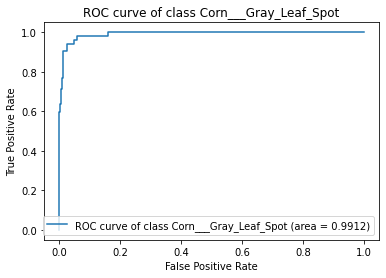

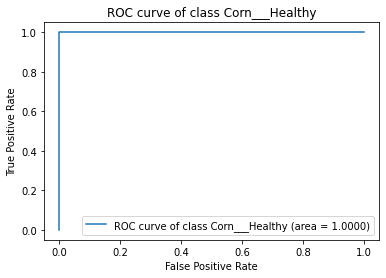

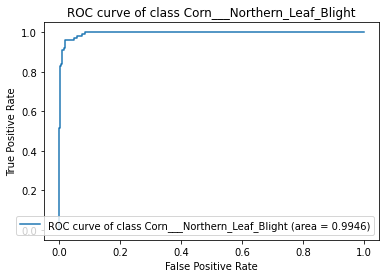

ROC AUC score: 0.9964426603328678


In [30]:
evaluate_model(incres_model, incres_history, test_generator)

In [31]:
from keras.layers import Input, Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU, SeparableConv2D
from keras.models import Model, Sequential
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 64
second_filters = 128
third_filters = 256

dropout_conv = 0.3
dropout_dense = 0.3

# create a model with separable convolutional layers
def custom_model():
    inputs = Input((224, 224, 3))
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(inputs)
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(x)
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation = "softmax")(x)
    model = Model(inputs = inputs, outputs = x)
    model.summary
    return model

In [32]:
model = custom_model()

In [33]:
model, history = train_model(model, train_generator, val_generator, 100, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 220, 220, 64)      36928     
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 218, 218, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 107, 107, 128)     7385


Test set accuracy: 0.9637305736541748 

25/25 [==============================] - 2s 68ms/step

                             precision    recall  f1-score   support

         Corn___Common_Rust       1.00      1.00      1.00       119
      Corn___Gray_Leaf_Spot       0.93      0.79      0.85        52
             Corn___Healthy       1.00      1.00      1.00       116
Corn___Northern_Leaf_Blight       0.90      0.97      0.93        99

                   accuracy                           0.96       386
                  macro avg       0.96      0.94      0.95       386
               weighted avg       0.96      0.96      0.96       386



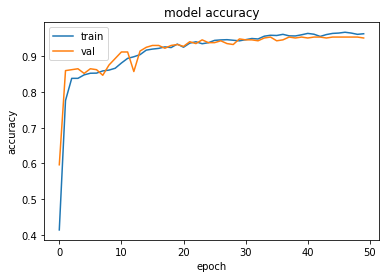

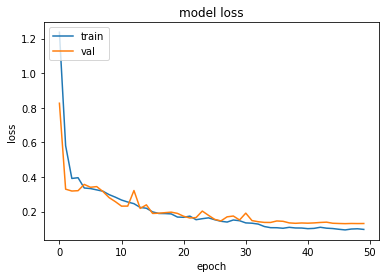

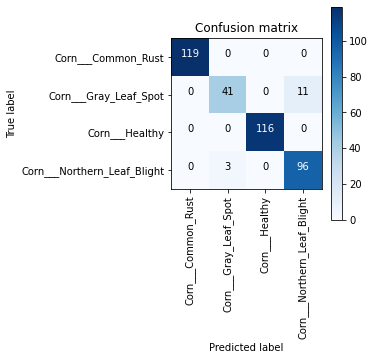

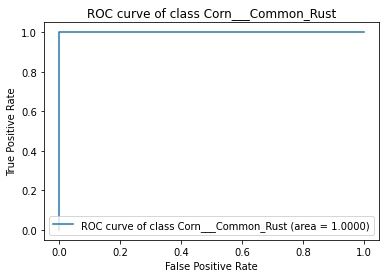

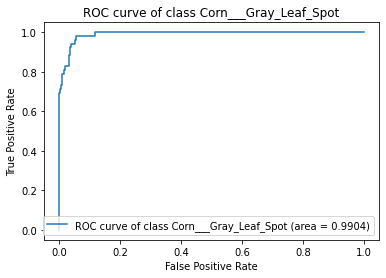

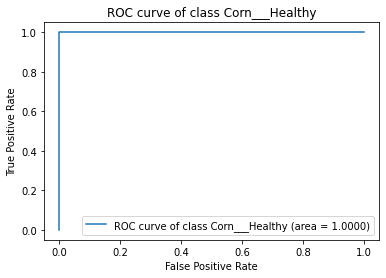

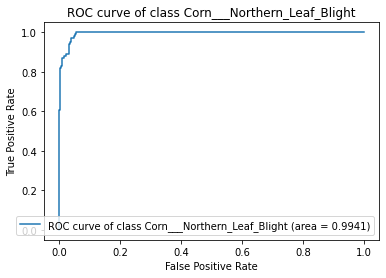

ROC AUC score: 0.9961267560352927


In [34]:
evaluate_model(model, history, test_generator)

In [35]:
inception_model = generate_model('inceptionv3', 4)


87916544/87910968 [==============================] - 1s 0us/step


In [36]:
inception_model, inception_history = train_model(inception_model, train_generator, val_generator, 50, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_212[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________


Test set accuracy: 0.9455958604812622 

25/25 [==============================] - 3s 53ms/step

                             precision    recall  f1-score   support

         Corn___Common_Rust       0.99      0.99      0.99       119
      Corn___Gray_Leaf_Spot       0.82      0.81      0.82        52
             Corn___Healthy       0.97      1.00      0.99       116
Corn___Northern_Leaf_Blight       0.92      0.90      0.91        99

                   accuracy                           0.95       386
                  macro avg       0.93      0.92      0.93       386
               weighted avg       0.94      0.95      0.95       386



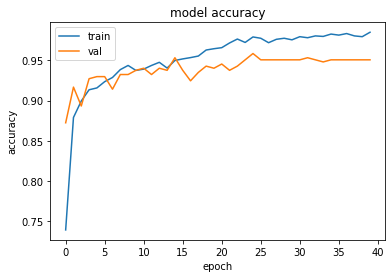

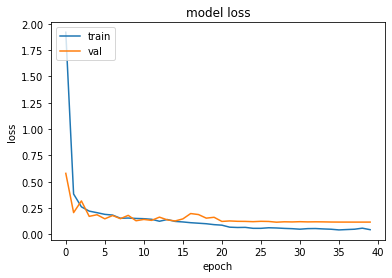

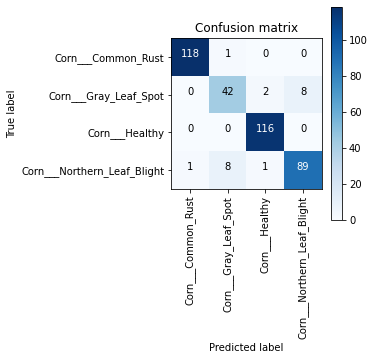

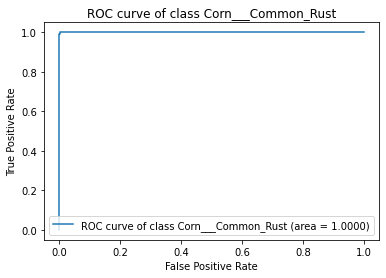

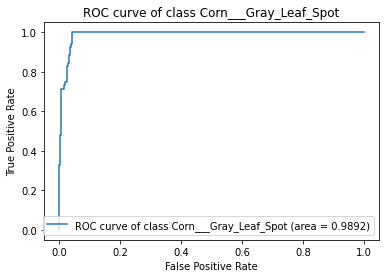

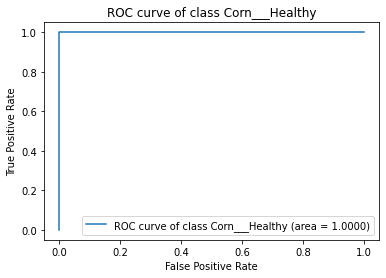

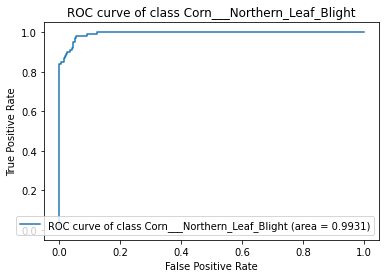

ROC AUC score: 0.9955670382739015


In [37]:
evaluate_model(inception_model, inception_history, test_generator)